<a href="https://www.kaggle.com/code/jiayii1/nlp-on-activesg-reviews?scriptVersionId=119871058" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
!pip install -q app_store_scraper

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## importing packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

from app_store_scraper import AppStore
activeSG = AppStore(country='sg', app_name='ActiveSG', app_id = '827595244')

In [6]:
activeSG.review(how_many=5000)

### converting data from json

In [7]:
activeSGDF = pd.DataFrame(np.array(activeSG.reviews),columns=['review'])
activeSGDF = activeSGDF.join(pd.DataFrame(activeSGDF.pop('review').tolist()))
activeSGDF.head(3)

,date,developerResponse,review,rating,isEdited,userName,title
0,2022-04-23 16:39:28,"{'id': 29393474, 'body': 'Dear member, with ef...",I’ve tried to log in into my account but unfor...,2,False,sitehh,Its very inconvenient
1,2020-12-20 23:20:19,"{'id': 22867589, 'body': 'Dear Benji, we are s...",For those experiencing login issues while usin...,1,False,Benji Nah,App full of bugs and glitches
2,2021-09-17 23:38:23,"{'id': 25199183, 'body': 'Dear member, thank y...",This is the first time in my life seeing this ...,1,False,5ziiii,This app should be named as “Active Singaporean”


In [8]:
activeSGDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               933 non-null    datetime64[ns]
 1   developerResponse  210 non-null    object        
 2   review             933 non-null    object        
 3   rating             933 non-null    int64         
 4   isEdited           933 non-null    bool          
 5   userName           933 non-null    object        
 6   title              933 non-null    object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 44.8+ KB


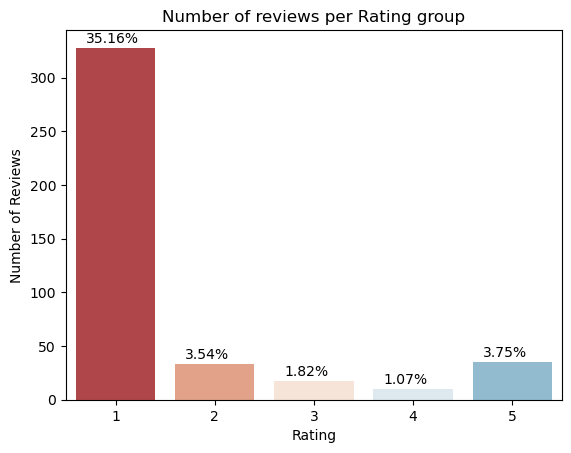

In [33]:
sns.set_palette("RdBu")
ax = sns.countplot(x=activeSGDF["rating"])
ax.set(xlabel='Rating', ylabel='Number of Reviews',
       title='Number of reviews per Rating group')

for p in ax.patches:
    txt = str(((p.get_height()/933)*100).round(2)) + '%'
    txt_x = p.get_x() + 0.1
    txt_y = p.get_height() +5
    ax.text(txt_x,txt_y,txt)

plt.show()

### data transformation

In [10]:
activeSGDF['review_lower'] = activeSGDF['review'].astype(str).str.lower()
activeSGDF.head(3)

,date,developerResponse,review,rating,isEdited,userName,title,review_lower
0,2022-04-23 16:39:28,"{'id': 29393474, 'body': 'Dear member, with ef...",I’ve tried to log in into my account but unfor...,2,False,sitehh,Its very inconvenient,i’ve tried to log in into my account but unfor...
1,2020-12-20 23:20:19,"{'id': 22867589, 'body': 'Dear Benji, we are s...",For those experiencing login issues while usin...,1,False,Benji Nah,App full of bugs and glitches,for those experiencing login issues while usin...
2,2021-09-17 23:38:23,"{'id': 25199183, 'body': 'Dear member, thank y...",This is the first time in my life seeing this ...,1,False,5ziiii,This app should be named as “Active Singaporean”,this is the first time in my life seeing this ...


In [11]:
activeSGDF = activeSGDF[activeSGDF["date"] > "2019"]

In [12]:
len(activeSGDF)

423

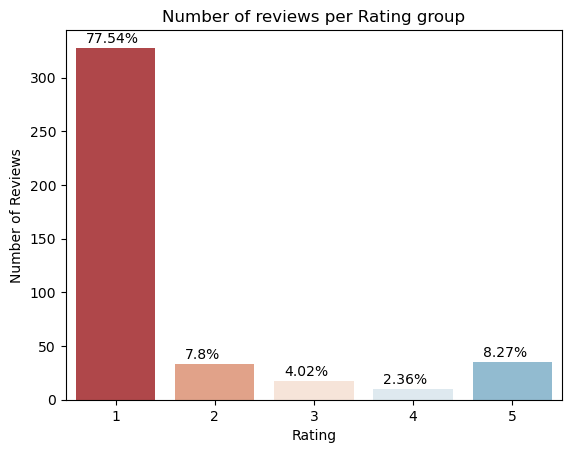

In [34]:
ax = sns.countplot(x=activeSGDF["rating"])
ax.set(xlabel='Rating', ylabel='Number of Reviews',
       title='Number of reviews per Rating group')

for p in ax.patches:
    txt = str(((p.get_height()/423)*100).round(2)) + '%'
    txt_x = p.get_x() + 0.1
    txt_y = p.get_height() +5
    ax.text(txt_x,txt_y,txt)

plt.show()

### extracting relevant features for topic modelling

In [14]:
tm_df = activeSGDF[["title", "review", "review_lower", "rating"]]
tm_df.head(3)

,title,review,review_lower,rating
0,Its very inconvenient,I’ve tried to log in into my account but unfor...,i’ve tried to log in into my account but unfor...,2
1,App full of bugs and glitches,For those experiencing login issues while usin...,for those experiencing login issues while usin...,1
2,This app should be named as “Active Singaporean”,This is the first time in my life seeing this ...,this is the first time in my life seeing this ...,1


## topic modelling using LDA

### converting reviews to document term matrix

In [15]:
# discards words that occur in more than 97% of documents, and include words that occur at least in 2 documents
cv = CountVectorizer(max_df=0.97, min_df=2, stop_words='english')
doc_term_matrix = cv.fit_transform(tm_df['review'])
doc_term_matrix

<423x839 sparse matrix of type '<class 'numpy.int64'>'
	with 5061 stored elements in Compressed Sparse Row format>

### hyperparameter tuning using gridsearch

In [16]:
lda=LatentDirichletAllocation(random_state=101, n_jobs=-1)
param_grid = { 
    'n_components': [3, 4, 5, 10, 15],
    'max_iter': [5, 10, 15, 20, 25],
    'learning_decay': [.5, .7, .9]
}

In [17]:
%%time
cv_lda = GridSearchCV(estimator=lda, param_grid=param_grid, n_jobs=-1)
cv_lda.fit(doc_term_matrix)

best_params = cv_lda.best_params_
best_params

CPU times: user 1.6 s, sys: 140 ms, total: 1.74 s
Wall time: 3min 54s


{'learning_decay': 0.5, 'max_iter': 20, 'n_components': 3}

### final LDA model

In [18]:
LDA=LatentDirichletAllocation(random_state=101, n_jobs=-1, learning_decay = best_params["learning_decay"], max_iter = best_params["max_iter"], n_components = best_params["n_components"])
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(learning_decay=0.5, max_iter=20, n_components=3,
                          n_jobs=-1, random_state=101)

In [19]:
for index,topic in enumerate(LDA.components_):
    print(f'topic #{index} : ')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-30:]])

topic #0 : 
['need', 'day', 'don', 'try', 'terrible', 'connect', 'court', 'available', 'activesg', 'bugs', 'crashes', 'single', 'work', 'captcha', 'pass', 'user', 'people', 'trying', 'make', 'just', 'unable', 'booked', 'facilities', 'time', 'slots', 'gym', 'booking', 'slot', 'book', 'app']
topic #1 : 
['gym', 'work', 'developer', 'unable', 'pls', 'user', 'pay', 'email', 'apps', 'activesg', 'like', 'try', 'swimming', 'using', 'tried', 'keeps', 'crashing', 'invalid', 'need', 'password', 'account', 'number', 'log', 'just', 'sign', 'singpass', 'use', 'fix', 'login', 'app']
topic #2 : 
['delete', 'connection', 'need', 'reset', 'password', 'unable', 'allow', 'apps', 'payment', 'account', 'just', 'pin', 'qr', 'code', 'steps', 'issue', 'passes', 'time', 'update', 'login', 'used', 'log', 'page', 'booking', 'working', 'singpass', 'sync', 'use', 'user', 'app']


In [20]:
tm_df = tm_df.reset_index(drop=True)

In [21]:
topic_results = LDA.transform(doc_term_matrix)
df_topic_results = pd.DataFrame(topic_results, columns=[
'0_Bookings',
'1_Login/Registration' ,
'2_Payment'
])
df_result = pd.merge(tm_df, df_topic_results,  how='inner', left_index=True, right_index=True )

In [22]:
def return_topic(row):
    if row["1_Login/Registration"] > row["0_Bookings"] and row["1_Login/Registration"] > row["2_Payment"]:
        return "Login/Registration"
    if row["0_Bookings"] > row["1_Login/Registration"] and row["0_Bookings"] > row["2_Payment"]:
        return "Bookings"
    if row["2_Payment"] > row["0_Bookings"] and row["2_Payment"] > row["1_Login/Registration"]:
        return "Payment"

In [23]:
df_result["review_topic"] = df_result.apply(lambda x: return_topic(x), axis=1)

In [24]:
df_result.head(5)

,title,review,review_lower,rating,0_Bookings,1_Login/Registration,2_Payment,review_topic
0,Its very inconvenient,I’ve tried to log in into my account but unfor...,i’ve tried to log in into my account but unfor...,2,0.009226,0.981011,0.009763,Login/Registration
1,App full of bugs and glitches,For those experiencing login issues while usin...,for those experiencing login issues while usin...,1,0.059328,0.005710,0.934963,Payment
2,This app should be named as “Active Singaporean”,This is the first time in my life seeing this ...,this is the first time in my life seeing this ...,1,0.985477,0.007023,0.007500,Bookings
3,Useable. Can be improved.,This app is not so bad. Can be used for bookin...,this app is not so bad. can be used for bookin...,4,0.399778,0.370003,0.230219,Bookings
4,Improvement needed on user friendliness,It's great that the app allows us to see what'...,it's great that the app allows us to see what'...,3,0.275456,0.716105,0.008438,Login/Registration


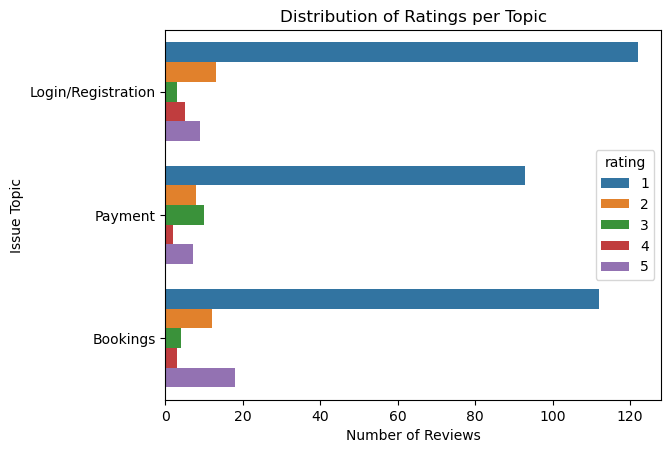

In [25]:
ax = sns.countplot(data=df_result, y="review_topic", hue="rating")
ax.set(xlabel='Number of Reviews', ylabel='Issue Topic',
       title='Distribution of Ratings per Topic')

plt.show()

We can see that features for login/registration created the most difficulty amongst users, followed by bookings and lastly payment for facilities. 

But people also seem to be quite satisfied with the booking features

## wordcloud of positive and negative reviews

In [26]:
# !pip install -q contractions

In [27]:
import nltk
import re
from nltk.corpus import stopwords
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'contractions'

In [ ]:
df_result.head(3)

In [ ]:
def clean_text(text):
    text = text.lower()
    ## remove \n \t and non-alphanumeric
    text = re.sub("(\\t|\\n)", " ", text)
    text = re.sub("[^a-zA-Z']", " ", text)
    text = re.sub("(?:_|[^a-z0-9_:])[;:=]+[\)\(\-\[\]\/|DPO]", "", text)
    text = re.sub("[0-9]+", "", text)
    text = text.strip()
    # expanding the contractions
    text = ' '.join([contractions.fix(x) for x in text.split(" ")])
    return text.strip()

df_result["review_lower"] = df_result["review_lower"].apply(lambda x: clean_text(x))

In [ ]:
#data pre-processing - LEMMATIZATION
def lemma_preprocess_text(text_list):
    processed_text = []
     
    #Tokenize words
    tokens = [word_tokenize(text) for text in text_list]
    
    #Remove stop words
    stop_list = stopwords.words('english')
    stop_list.append("filler")
    text_stop = [[word for word in doc if word.lower() not in stop_list] for doc in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text_lemma = [[lemmatizer.lemmatize(word) for word in doc] for doc in text_stop]
    
    return text_lemma

In [ ]:
# Put each row of the 'text' column into a list on its own
text_list = df_result['review_lower'].tolist()

# Preprocess the text_list
lemma_processed_text = lemma_preprocess_text(text_list)

# Add the processed_text list as a new column in the dataframe
df_result['lemmatized_processed_text'] = lemma_processed_text

# Preview the processed data
df_result.head(3)

In [ ]:
# reviews with rating >= 4
four_and_five = df_result[df_result['rating'] >= 4]

# reviews with rating < 4
less_than_4 = df_result[df_result['rating'] < 4]

### normal word cloud

In [ ]:
# 4&5 RATINGS  - word cloud

# extract the processed text column as a list of lists

four_and_five_text = four_and_five['lemmatized_processed_text'].tolist()

# join each inner list into a single string
four_and_five_rev_text = [" ".join(x) for x in four_and_five_text]

# join the list of strings into a single string
four_and_five_rev_text = " ".join(four_and_five_rev_text)

# tokenize the words
four_and_five_rev_tokens = word_tokenize(four_and_five_rev_text)

# create a word cloud
review_wordcloud = WordCloud(width = 3000, height = 2000, background_color="white").generate(" ".join(four_and_five_rev_tokens))

# plot the word cloud
plt.figure(figsize=(8,6))
plt.imshow(review_wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Positive Reviews")
plt.axis("off")
plt.show()

In [ ]:
# LESS THAN 4 RATINGS  - word cloud

# extract the processed text column as a list of lists

less_than_4_text = less_than_4['lemmatized_processed_text'].tolist()

# join each inner list into a single string
less_than_4_rev_text = [" ".join(x) for x in less_than_4_text]

# join the list of strings into a single string
less_than_4_rev_text = " ".join(less_than_4_rev_text)

# tokenize the words
less_than_4_rev_tokens = word_tokenize(less_than_4_rev_text)

# create a word cloud
# wordcloud = WordCloud().generate(" ".join(tokens))
review_wordcloud = WordCloud(width = 3000, height = 2000, background_color="black").generate(" ".join(less_than_4_rev_tokens))

# plot the word cloud
plt.figure(figsize=(8,6))
plt.imshow(review_wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Negative Reviews")
plt.axis("off")
plt.show()

### word cloud with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# MORE THAN 4 RATINGS  - word cloud

tfidf_more_than_4_text = four_and_five['lemmatized_processed_text'].tolist()

# join each inner list into a single string
tfidf_more_than_4_rev_text = [" ".join(x) for x in tfidf_more_than_4_text]

# print(tfidf_more_than_4_rev_text)

more_than_4_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .6, min_df = .01)

X_moreThan4 = more_than_4_vectorizer.fit_transform(tfidf_more_than_4_rev_text)

dense = X_moreThan4.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=more_than_4_vectorizer.get_feature_names_out())

tf_idf_counter_moreThan4 = df.transpose().sum(axis=1)

wordcloud = WordCloud(width = 3000, height = 2000, background_color='white')
wordcloud.generate_from_frequencies(tf_idf_counter_moreThan4)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Positive Reviews")
plt.axis("off")
plt.show()

In [ ]:
# LESS THAN 4 RATINGS  - word cloud

tfidf_less_than_4_text = less_than_4['lemmatized_processed_text'].tolist()

# join each inner list into a single string
tfidf_less_than_4_rev_text = [" ".join(x) for x in tfidf_less_than_4_text]

# print(tfidf_less_than_4_rev_text)

less_than_4_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .6, min_df = .01)

X_LessThan4 = less_than_4_vectorizer.fit_transform(tfidf_less_than_4_rev_text)

dense = X_LessThan4.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=less_than_4_vectorizer.get_feature_names_out())

tf_idf_counter_LessThan4 = df.transpose().sum(axis=1)

wordcloud = WordCloud(width = 3000, height = 2000, background_color='black')
wordcloud.generate_from_frequencies(tf_idf_counter_LessThan4)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Negative Reviews")
plt.axis("off")
plt.show()

## sentiment analysis using VADER

In [ ]:
# !pip install -q vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
vader_sentiment = SentimentIntensityAnalyzer()
def vader_sentiment_scores(text):
    score = vader_sentiment.polarity_scores(text)
    return score['compound']

In [ ]:
df_result['senti_scores_compound'] = df_result['review'].apply(lambda review: vader_sentiment_scores(review))

In [ ]:
df_result.head(3)

In [ ]:
df_result.boxplot(column=['senti_scores_compound'], by='rating').set(xlabel='Rating')
plt.title('') 
plt.ylabel('Compound Sentiment Scores')
plt.show()

In [ ]:
df_result.tail(5)

In [ ]:
df_result.query("review_topic == 'Bookings'")["review_lower"]

In [ ]:
df_result.iloc[421]["review_lower"]